# Transfer learning and pets

We are going to use transfer learning on pets to transfer weights from a lower number of classes (just terriers) (5) to a larger number of classes (37). 

This builds on the lesson 1 pets found here: https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson1-pets.ipynb

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
# Need to set correct GPU
torch.cuda.set_device(1)
from fastai.callbacks.tracker import EarlyStoppingCallback
from fastai.callbacks.tracker import SaveModelCallback


In [3]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

If you have gone through lesson1 this should all work

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

In [4]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url: str, fname: Union[pathlib.Path, str] = None, dest: Union[pathlib.Path, str] = None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if it doesn't exist, and un-tgz to folder `dest`.



In [5]:
path = untar_data(URLs.PETS); path

PosixPath('/home/jd/.fastai/data/oxford-iiit-pet')

In [6]:
path.ls()

[PosixPath('/home/jd/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/home/jd/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/home/jd/.fastai/data/oxford-iiit-pet/images2')]

In [7]:
## THIS IS NEW HERE. We want to make a smaller dataset of just terriers.
!mkdir {path}/'images2'
!cp {path}/images/*terrier* {path}/images2/
path_img = path/'images2'
path.ls()

mkdir: cannot create directory ‘/home/jd/.fastai/data/oxford-iiit-pet/images2’: File exists


[PosixPath('/home/jd/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/home/jd/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/home/jd/.fastai/data/oxford-iiit-pet/images2')]

In [8]:
#You should now be seeing the terriers in images2
!ls {path}/'images2'/

american_pit_bull_terrier_100.jpg   staffordshire_bull_terrier_198.jpg
american_pit_bull_terrier_101.jpg   staffordshire_bull_terrier_199.jpg
american_pit_bull_terrier_102.jpg   staffordshire_bull_terrier_19.jpg
american_pit_bull_terrier_103.jpg   staffordshire_bull_terrier_1.jpg
american_pit_bull_terrier_104.jpg   staffordshire_bull_terrier_200.jpg
american_pit_bull_terrier_105.jpg   staffordshire_bull_terrier_201.jpg
american_pit_bull_terrier_106.jpg   staffordshire_bull_terrier_202.jpg
american_pit_bull_terrier_107.jpg   staffordshire_bull_terrier_20.jpg
american_pit_bull_terrier_108.jpg   staffordshire_bull_terrier_21.jpg
american_pit_bull_terrier_109.jpg   staffordshire_bull_terrier_22.jpg
american_pit_bull_terrier_10.jpg    staffordshire_bull_terrier_23.jpg
american_pit_bull_terrier_110.jpg   staffordshire_bull_terrier_24.jpg
american_pit_bull_terrier_111.jpg   staffordshire_bull_terrier_25.jpg
american_pit_bull_terrier_112.jpg   staffordshire_bull_terrier_26.jpg
american_pit_bul

In [9]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/home/jd/.fastai/data/oxford-iiit-pet/images2/yorkshire_terrier_103.jpg'),
 PosixPath('/home/jd/.fastai/data/oxford-iiit-pet/images2/scottish_terrier_113.jpg'),
 PosixPath('/home/jd/.fastai/data/oxford-iiit-pet/images2/wheaten_terrier_56.jpg'),
 PosixPath('/home/jd/.fastai/data/oxford-iiit-pet/images2/yorkshire_terrier_80.jpg'),
 PosixPath('/home/jd/.fastai/data/oxford-iiit-pet/images2/scottish_terrier_62.jpg')]

In [10]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [11]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

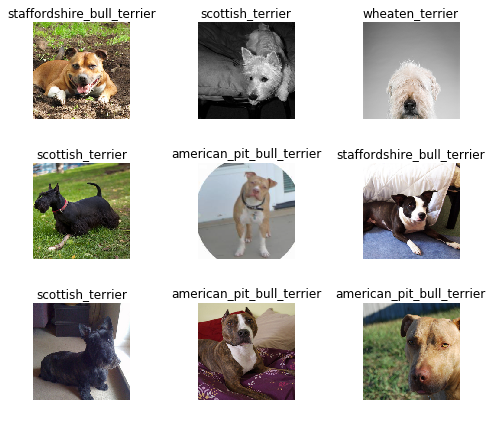

In [12]:
data.show_batch(rows=3, figsize=(7,6))

In [13]:
# Check our data, you should only see terriers
print(data.classes)
len(data.classes),data.c

['american_pit_bull_terrier', 'scottish_terrier', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(5, 5)

## Training: resnet34 on the terriers
We are going to load and train the terriers

In [14]:
learn = cnn_learner(data,
                    models.resnet34,
                   metrics=[accuracy,error_rate]
                    ,callback_fns=[ShowGraph]
                   ).mixup()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.74E-03


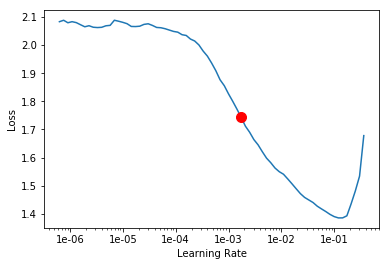

In [15]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.996424,1.478574,0.393939,0.606061,00:07
1,1.749535,0.835835,0.762626,0.237374,00:07
2,1.482406,0.361621,0.888889,0.111111,00:07
3,1.275756,0.227064,0.934343,0.065657,00:07
4,1.137349,0.216746,0.944444,0.055556,00:07
5,1.052927,0.223421,0.939394,0.060606,00:07
6,0.972317,0.223690,0.934343,0.065657,00:07


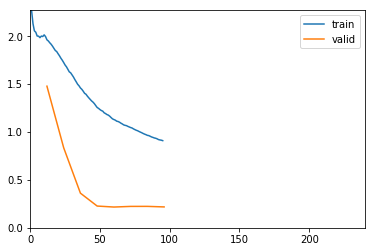

Better model found at epoch 0 with accuracy value: 0.39393940567970276.
Better model found at epoch 1 with accuracy value: 0.7626262903213501.
Better model found at epoch 2 with accuracy value: 0.8888888955116272.
Better model found at epoch 3 with accuracy value: 0.9343434572219849.
Better model found at epoch 4 with accuracy value: 0.9444444179534912.
Epoch 7: early stopping


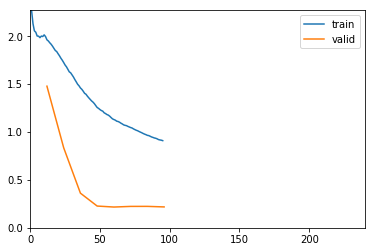

In [16]:
learn.fit_one_cycle(20, 1e-03, 
 callbacks=[EarlyStoppingCallback(learn,monitor='accuracy', min_delta=0.001, patience=2),
            SaveModelCallback(learn, every='improvement', monitor='accuracy', name='bestdog')
           ], wd=0.1)

In [17]:
learn.load('bestdog')

Learner(data=ImageDataBunch;

Train: LabelList (792 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
yorkshire_terrier,wheaten_terrier,yorkshire_terrier,scottish_terrier,yorkshire_terrier
Path: /home/jd/.fastai/data/oxford-iiit-pet/images2;

Valid: LabelList (198 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
yorkshire_terrier,staffordshire_bull_terrier,yorkshire_terrier,staffordshire_bull_terrier,yorkshire_terrier
Path: /home/jd/.fastai/data/oxford-iiit-pet/images2;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(

In [18]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.74E-05


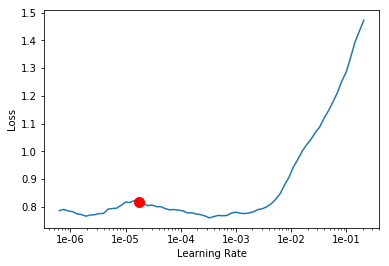

In [19]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.756042,0.214762,0.944444,0.055556,00:07
1,0.787338,0.216138,0.944444,0.055556,00:07
2,0.800574,0.216130,0.944444,0.055556,00:07
3,0.791509,0.214154,0.934343,0.065657,00:07
4,0.780437,0.213126,0.934343,0.065657,00:08
5,0.769828,0.210188,0.934343,0.065657,00:07


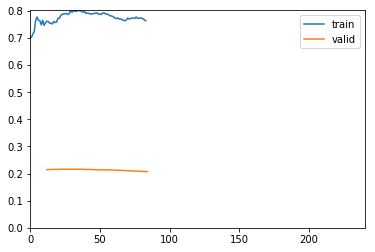

Better model found at epoch 0 with accuracy value: 0.9444444179534912.
Epoch 6: early stopping


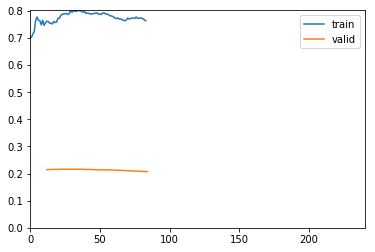

In [20]:
learn.fit_one_cycle(20, max_lr=slice(5e-05,1e-06), 
 callbacks=[EarlyStoppingCallback(learn,monitor='accuracy', min_delta=0.001, patience=5),
            SaveModelCallback(learn, every='improvement', monitor='accuracy', name='bestdog')
           ], wd=0.1)

## Results

In [21]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

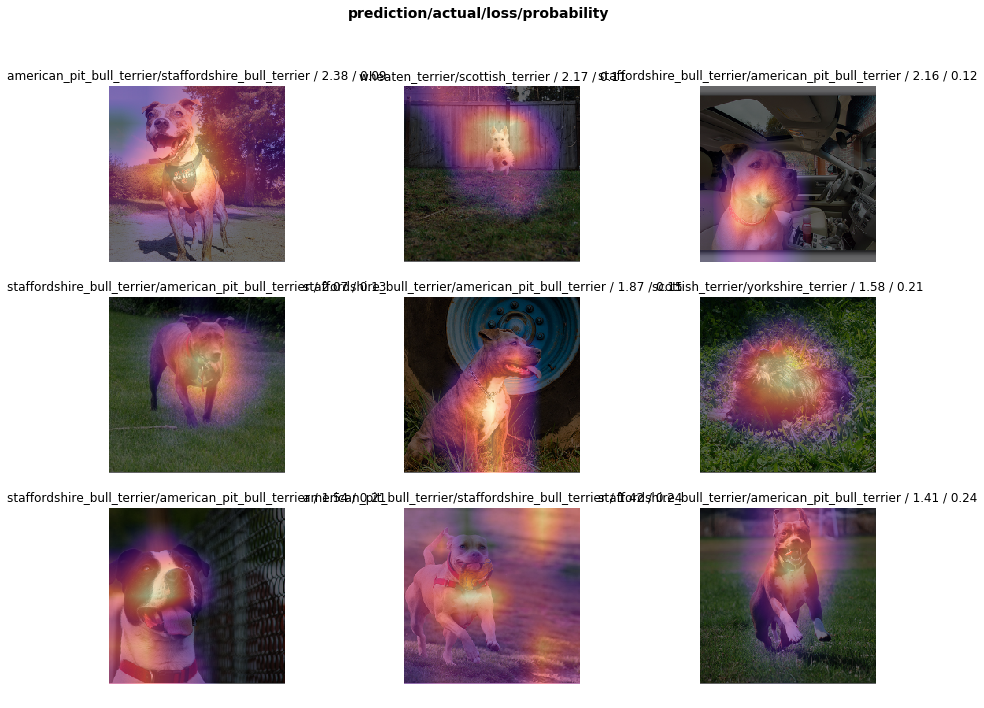

In [22]:
interp.plot_top_losses(9, figsize=(15,11))

In [23]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 7),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 2)]

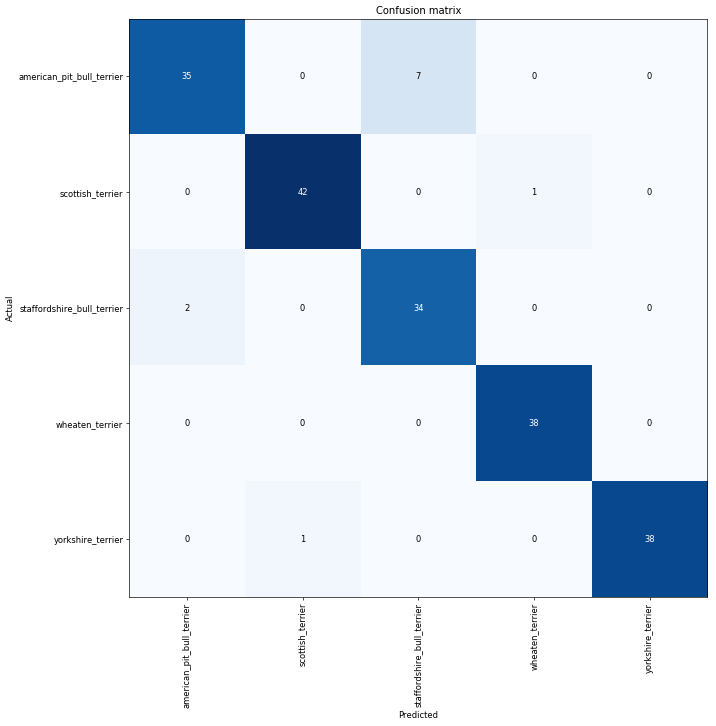

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

## Transfer Time
Now that we have weights for the 5 terriers we want to use those for the 37 classes in Cats and Dogs. Notice line 9  in Summary below. This is what we are changing.
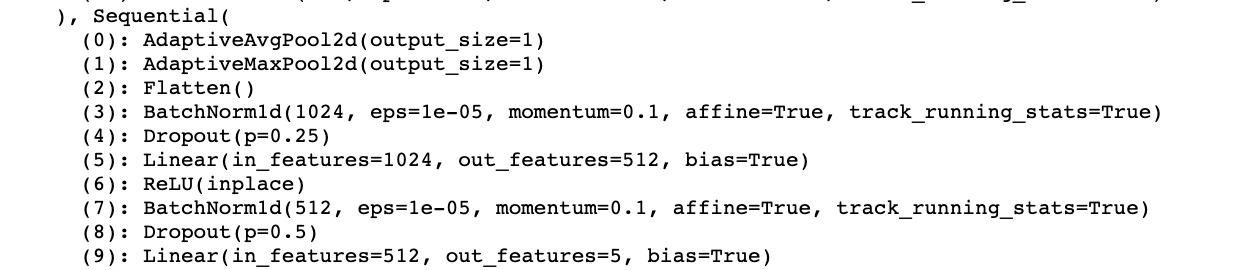

In [ ]:
learn.summary

<bound method model_summary of Learner(data=ImageDataBunch;

Train: LabelList (792 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
yorkshire_terrier,wheaten_terrier,yorkshire_terrier,scottish_terrier,yorkshire_terrier
Path: /home/jd/.fastai/data/oxford-iiit-pet/images2;

Valid: LabelList (198 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
yorkshire_terrier,staffordshire_bull_terrier,yorkshire_terrier,staffordshire_bull_terrier,yorkshire_terrier
Path: /home/jd/.fastai/data/oxford-iiit-pet/images2;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_m

In [ ]:
# Load old weights
learn.load('bestdog')
# Change classes to the new number of classes; there might be a more clever way; however, I know there are 37
newNumberOfClasses=37
# Replace Linear layer output with 37
learn.model[-1][-1]=nn.Linear(in_features=512,out_features=newNumberOfClasses, bias=True)
# Save the new weights
learn.save('NewModel')

### Start loading the new model. Or the full cats and dogs

In [ ]:
path_anno = path/'annotations'
path_img = path/'images'

In [ ]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/home/jd/.fastai/data/oxford-iiit-pet/images/english_cocker_spaniel_102.jpg'),
 PosixPath('/home/jd/.fastai/data/oxford-iiit-pet/images/newfoundland_145.jpg'),
 PosixPath('/home/jd/.fastai/data/oxford-iiit-pet/images/basset_hound_174.jpg'),
 PosixPath('/home/jd/.fastai/data/oxford-iiit-pet/images/chihuahua_11.jpg'),
 PosixPath('/home/jd/.fastai/data/oxford-iiit-pet/images/Bengal_128.jpg')]

In [ ]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [ ]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

In [ ]:
learn = cnn_learner(data,
                    models.resnet34,
                   metrics=[error_rate]
                    ,callback_fns=[ShowGraph]
                   ).mixup()

In [ ]:
# Note we are using the old path to images2
learn.load(str(path)+'/images2/models/NewModel')

Learner(data=ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
english_cocker_spaniel,newfoundland,basset_hound,Abyssinian,leonberger
Path: /home/jd/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Persian,pomeranian,great_pyrenees,Birman,japanese_chin
Path: /home/jd/.fastai/data/oxford-iiit-pet/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(

## Does it run?

epoch,train_loss,valid_loss,error_rate,time
0,2.140556,0.480879,0.100812,00:49
1,1.532602,0.394515,0.112314,00:50


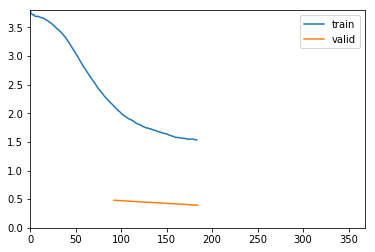

In [ ]:
learn.fit_one_cycle(4)

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

In [ ]:
doc(interp.plot_top_losses)

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=2)

## Compare with Lesson 1
While we could compare both start and the end. Pets 1 isn't really tweaked crazy good. So just looking at the first 4 iterations.

First four cycles look like this: With .10 going down to .07

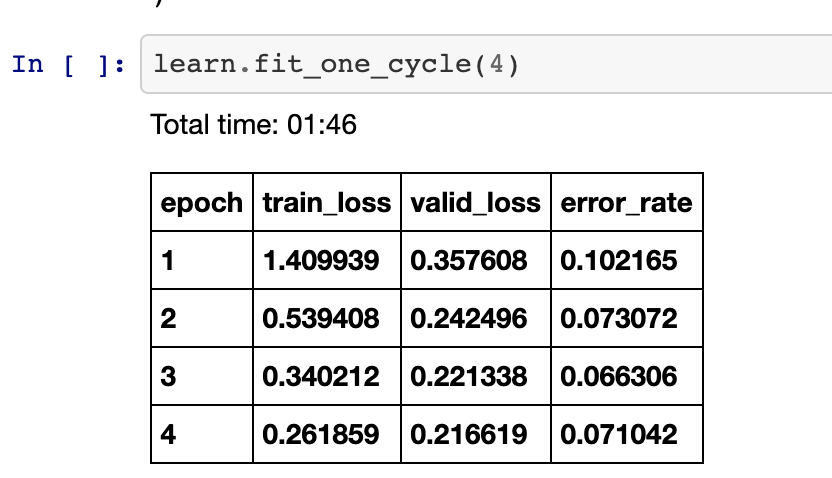

Pre-train on Terriers allow us to start with: .12 going down to .08
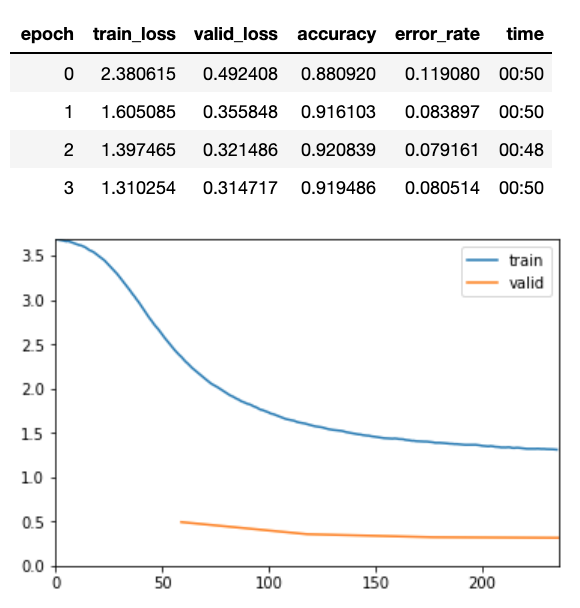